Importing Image Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Reading all the training data as 100x100 images

In [ ]:
import numpy as np
import math
from PIL import *
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
happ_loc=['01','02','04','06','07','09','10','12','13']
sad_loc=['02','03','04','05','06','07','09','10','11','12','13']
happy_images = []
for i in happ_loc:
  loc='drive/MyDrive/Data/emotion_classification/train/subject'+i+'.happy.gif'
  img=Image.open(loc)
  img1=img.resize((100,100))
  img_arr=np.array(img1)
  img_arr=img_arr.reshape(10000,)
  happy_images.append(img_arr)
happyImages=np.array(happy_images)
sad_images = []
for i in sad_loc:
  loc='drive/MyDrive/Data/emotion_classification/train/subject'+i+'.sad.gif'
  img=Image.open(loc)
  img1=img.resize((100,100))
  img_arr=np.array(img1)
  img_arr=img_arr.reshape(10000,)
  sad_images.append(img_arr)
sadImages=np.array(sad_images)

Normalizing the images, calculating sample covarince matrix and eigenvalue, eigenvectors for it

In [ ]:
happyImages = happyImages/255
sadImages = sadImages/255
temp1=[]
for i in happyImages:
  temp1.append(i)
for i in sadImages:
  temp1.append(i)
X=np.array(temp1)
X=np.transpose(X)
Xm = X.mean(axis=1)
Xm = np.reshape(Xm, (10000,1))
N=20
Sx = np.dot(np.transpose(X - Xm), (X - Xm))/N
lambda_all, V_all = np.linalg.eigh(Sx)

Doing PCA for higher dimension to reduce running time and for efficincy. K=18 gives the best separation as seen by plotting the projection on LDA.

In [ ]:
idx = np.argsort(lambda_all)
idx=idx[::-1]
lambdas = lambda_all[idx]
V = V_all[:,idx]
k = 18  
V_PCA = V[:,0:k] 

Converting lower dimension eigenvectors to higher dimension(dimension of feature vector)

In [ ]:
U = np.zeros((10000,1)) 
index = 0
for v in np.transpose(V_PCA):
  x = v.reshape((20,1))
  den = math.sqrt(abs(lambdas[index]*20))
  u = np.dot(X,x)/den
  U = np.append(U,u,axis = 1)
  index += 1
U = np.array(U) 
U = U[:,1:]

Applying PCA on happy images and sad images

In [ ]:
happyImages=np.transpose(happyImages)
sadImages=np.transpose(sadImages)
PCA_Happy = np.dot(U.T, happyImages)
PCA_Sad = np.dot(U.T, sadImages)
Xm_Happy = PCA_Happy.mean(axis=1)
Xm_Sad = PCA_Sad.mean(axis=1)
Xm_Happy = np.reshape(Xm_Happy,(k,1))
Xm_Sad = np.reshape(Xm_Sad,(k,1))

Doing LDA on images after PCA. Calculating between class covarince mtrix and within class covarince matrix

In [ ]:
Sb = np.dot((Xm_Happy - Xm_Sad), (Xm_Happy.T - Xm_Sad.T))
Sw = np.dot((PCA_Happy - Xm_Happy), np.transpose(PCA_Happy - Xm_Happy))/9 + np.dot((PCA_Sad - Xm_Sad), np.transpose(PCA_Sad - Xm_Sad))/11
Swinv = np.linalg.inv(Sw)

Finding W for maximum fisher ratio solution

In [ ]:
lambda_LDA_temp, W_temp = np.linalg.eigh(np.dot(Swinv, Sb))
idx = lambda_LDA_temp.argsort()[::-1]
sorted_Lambda_LDA = lambda_LDA_temp[idx]
sorted_W = W_temp[:, idx]
W = sorted_W[:,0]
W = W.reshape((k,1))

Plotting the projected LDA data on 1 dimension and checking the class separation 

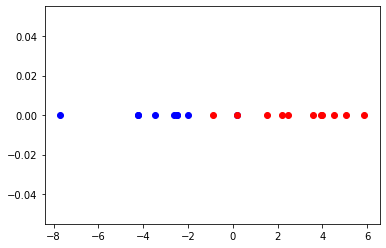

In [ ]:
Happy_proj = np.dot(np.transpose(W), PCA_Happy)
Sad_proj = np.dot(np.transpose(W), PCA_Sad)
plt.scatter(Happy_proj ,np.zeros((9,), dtype = int),color = 'b') 
plt.scatter(Sad_proj ,np.zeros((11,),dtype = int), color = 'r') 
plt.show()


As we can see K=18 gives very good separatibility. Separatibility scatter plot for K=5,10,15,17,18,20 is attached at question end.

Reading the test data images

In [ ]:
test_happ_loc=['03','05','08','11','14','15']
test_sad_loc=['01','08','14','15']
test_images = []
for i in test_happ_loc:
  loc='drive/MyDrive/Data/emotion_classification/test/subject'+i+'.happy.gif'
  img=Image.open(loc)
  img1=img.resize((100,100))
  img_arr=np.array(img1)
  img_arr=img_arr.reshape(10000,)
  test_images.append(img_arr)
for i in test_sad_loc:
  loc='drive/MyDrive/Data/emotion_classification/test/subject'+i+'.sad.gif'
  img=Image.open(loc)
  img1=img.resize((100,100))
  img_arr=np.array(img1)
  img_arr=img_arr.reshape(10000,)
  test_images.append(img_arr)
testImages=np.array(test_images)
testImages = np.array(test_images)/255
testImages = np.transpose(testImages)
print(testImages.shape)
print(U.shape)

(10000, 10)
(10000, 18)


Performing PCA and LDA on test images and checking the classification accuracy. 100% classification accuracy achived for k=18. Classification accuracy of 100% achived using suitable separation point (val=0.8) on LDA projection. 

In [ ]:
PCA_test_images = np.dot(U.T, testImages)
LDA_test_images = np.dot(W.T, PCA_test_images)
index = 0
for element in LDA_test_images.T:
  index += 1 
  if element >= 0.8:
    print(f"{index} is SAD ",end="")
    # sad_pred.append(element) 
  else :
    print(f"{index} is HAPPY ",end="")
    # happy_pred.append(element)
  if index <= 6: # first 5 row-vectors are form HAPPy images
    print(",Actual status = HAPPY") 
  else:
    print(",Actual status = SAD")

1 is HAPPY ,Actual status = HAPPY
2 is HAPPY ,Actual status = HAPPY
3 is HAPPY ,Actual status = HAPPY
4 is HAPPY ,Actual status = HAPPY
5 is HAPPY ,Actual status = HAPPY
6 is HAPPY ,Actual status = HAPPY
7 is SAD ,Actual status = SAD
8 is SAD ,Actual status = SAD
9 is SAD ,Actual status = SAD
10 is SAD ,Actual status = SAD


Using K=18 and threshold value of 0.8 gave best resuls on data set. Even, K=15 and threshold = 0.6 gives 100% accurate resuls.

Increasing K further also leads to increase in within class variance thus reducing the accuracy of separation as can be seen below. Because of high within class varince the data begins to overlap instead of separating. 